In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output

In [3]:
start = timer()
prep_dataset1 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized1.csv', delimiter=",")



# Normalizing

In [4]:
def normalizing(df):
    f_columns = ['temperature','label']
    scaler1 = StandardScaler().fit(df)
    scaler2 = StandardScaler().fit(df)

    scaler1= scaler1.fit(df[f_columns].to_numpy())
    scaler2 = scaler2.fit(df[['delay']])

    df.loc[:,f_columns] = scaler1.transform(df[f_columns].to_numpy())
    df['delay'] = scaler2.transform(df[['delay']])
    return df


def unormalizing(df,Y_test,y_pred ):
    scaler = StandardScaler().fit(df)
    scaler = scaler.fit(df[['delay']])
    y_test_inv = scaler.inverse_transform(Y_test.reshape(1,-1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    return y_test_inv, y_pred_inv


In [5]:
def saveFile(dataset, name='dataset'):
    print('saving: ',name, '......')
    f = open(name,'w')
    try:
        writer = csv.writer(f)
        writer.writerow(dataset.columns)
        for i in np.arange(int(dataset.shape[0])):
            writer.writerow(dataset.iloc[i,])
    finally:
        f.close()
        

def preprocessing(dataset, order): 
    window = 20
    cont = 0;
    cols = ['timestamp','temperature','label' ,'delay' ]
    newSet = []
    while(cont<dataset.shape[0]):
        MyLIst = dataset.iloc[cont:cont+window,:]
        cont+=20
        deltaT = np.max(MyLIst.temperature) - np.min(MyLIst.temperature)
        deltaTime = np.max(MyLIst.seconds) - np.min(MyLIst.seconds)
        meanDelay = np.mean(MyLIst.delay)
        label=MyLIst.iloc[0,3]   
        newSet.append([deltaTime,deltaT,label,meanDelay])
    delta_df = pd.DataFrame(np.array(newSet), columns = cols)
    saveFile(delta_df, 'datasets/delta/sdn_train_mininet_unormalized_'+order+'.csv')
    norm = normalizing(delta_df)
    saveFile(norm, 'datasets/delta/sdn_train_mininet_normalized_'+order+'.csv')

    return norm
    

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []    
    for i in range(len(X) - time_steps):
        clear_output(wait=True)
        print('modeling to keras ',round((i/(len(X) - time_steps))*100,2), ('%'), end='')
        s = round(timer() - start)
        if(s>60):
            s /=60
            print(' ', s, ' seconds')
        v = X.iloc[i: (i+time_steps), 0:3].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
preprocessing(prep_dataset1, '1')
preprocessing(prep_dataset2, '2')
preprocessing(prep_dataset3, '3')
preprocessing(prep_test, 'test')

saving:  datasets/delta/sdn_train_mininet_unormalized_1.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_1.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_2.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_2.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_3.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_3.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_test.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_test.csv ......


,timestamp,temperature,label,delay
0,3030.0,2.855213,-0.098934,-0.046209
1,1740.0,-0.192323,-0.098934,-0.046209
2,1320.0,-0.275437,-0.098934,-0.046209
3,1590.0,-0.303142,-0.098934,-0.046209
4,1500.0,-0.303142,-0.098934,-0.046209
...,...,...,...,...
1233,2583.0,0.250955,-0.098934,-0.046209
1234,3007.0,0.306365,-0.098934,-0.046209
1235,2910.0,0.638823,-0.098934,-0.046209
1236,2909.0,0.888167,-0.098934,-0.046209


In [11]:
def LSTMconf(X_train):
    print('Init config MPL')
    #configurando rede para treinamento
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(activation="relu", input_dim=3, units=10, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    
    loss ="mse"
    optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001)
    metrics=["accuracy"]

    model.compile(loss=loss, optimizer=optim, 
             metrics=metrics
             )
    return model
    

In [29]:
def LSTMfit(model,X_train,Y_train):
    print('Init Train')
    start = timer()
    history = model.fit(
        X_train, Y_train, 
        epochs=100, 
        batch_size= 64,
        validation_split=0.25,
        shuffle=False,
    #     callbacks=[tensorboard_callback]
    )
    return history


In [30]:
model = None
for i in range(1,4):
    train = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_'+str(i)+'.csv', delimiter=",")     
    X_train,Y_train = create_dataset(train, train.delay)
    if(model is None):
        model = LSTMconf(X_train)
    history = LSTMfit(model,X_train, Y_train)

# r = Timer(1.0, preprocessing, (prep_dataset.iloc[cont:cont+window,:]))
# r.start()
# print(X_train)
    

modeling to keras  99.94 %  7.816666666666666  seconds
Init Train
Epoch 1/100
19/19 [==============================] - 0s 10ms/step - loss: 1.3345 - accuracy: 0.0000e+00 - val_loss: 4.1794e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3375 - accuracy: 0.0000e+00 - val_loss: 4.1929e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 1.3353 - accuracy: 0.0000e+00 - val_loss: 4.2042e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3357 - accuracy: 0.0000e+00 - val_loss: 4.2077e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3361 - accuracy: 0.0000e+00 - val_loss: 4.2081e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3350 - accuracy: 0.0000e+00 - val_loss: 4.2105e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
19/

Epoch 54/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3367 - accuracy: 0.0000e+00 - val_loss: 4.5993e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3346 - accuracy: 0.0000e+00 - val_loss: 4.6031e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3359 - accuracy: 0.0000e+00 - val_loss: 4.6002e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3362 - accuracy: 0.0000e+00 - val_loss: 4.6016e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3357 - accuracy: 0.0000e+00 - val_loss: 4.6044e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3385 - accuracy: 0.0000e+00 - val_loss: 4.6203e-04 - val_accuracy: 0.0000e+00
Epoch 60/100
19/19 [==============================] - 0s 4ms/step - loss: 1.

In [31]:
print('Saving Model')
model.save('models/lstm')

Saving Model
INFO:tensorflow:Assets written to: models/lstm\assets


# loss training

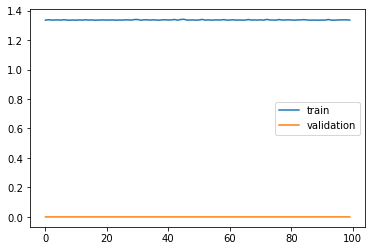

In [32]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend();

In [33]:
test = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_test.csv', delimiter=",")     
X_test,Y_test = create_dataset(test, test.delay)

modeling to keras  99.92 %  8.1  seconds


# predicting

In [34]:
y_pred = model.predict(X_test)

# unormalizing

In [35]:
y_test_inv, y_pred_inv = unormalizing(test, Y_test, y_pred)

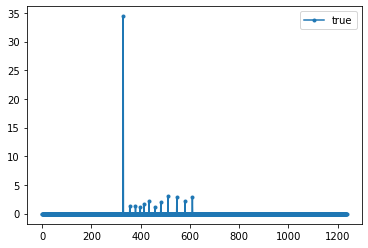

In [36]:
fig2 = plt.figure()
a2 = fig2.add_subplot(1,1,1)
a2.plot(y_test_inv.flatten(), marker='.', label='true')
a2.legend();

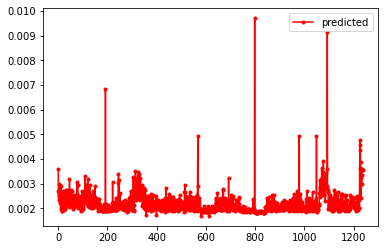

In [37]:
fig3 = plt.figure()
a3 = fig3.add_subplot(1,1,1)
a3.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a3.legend();

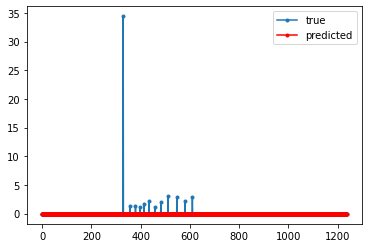

In [38]:
fig4 = plt.figure()
a4 = fig4.add_subplot(1,1,1)

a4.plot(y_test_inv.flatten(), marker='.', label='true')
a4.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a4.legend();

In [39]:
l1 = []
l2 = []
for i in np.arange(y_pred_inv.shape[0]):
    clear_output(wait=True)
    print('progress ',round((i/y_pred_inv.shape[0])*100,2), ('%'))
    if(y_pred_inv[i,0]<=10):
        l1.append(y_pred_inv[i,0])
    if(y_test_inv[0,i]<=10):
        l2.append(y_test_inv[0,i])

y_pred_inv2 = np.array(l1)
y_test_inv2 = np.array(l2)

progress  99.92 %


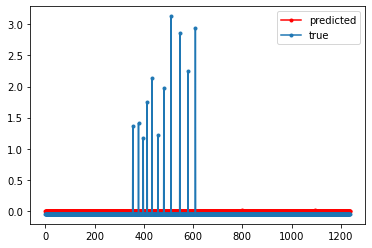

In [40]:
plt.plot(y_pred_inv2.flatten(),'r',marker='.', label='predicted')
plt.plot(y_test_inv2.flatten(), marker='.', label='true')
plt.legend();

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [42]:
rmse =  mean_squared_error(y_test_inv2, y_pred_inv2[0:1236], squared=False)
mae =  mean_absolute_error(y_test_inv2, y_pred_inv2[0:1236])
median_mae = median_absolute_error(y_test_inv2, y_pred_inv2[0:1236])


print(rmse)
print(mae)
print(median_mae)

0.2065690870604554
0.06596003378599731
0.04831866192650587


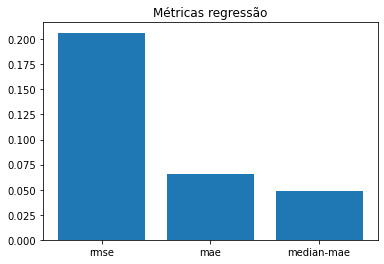

In [43]:
objects = ('rmse', 'mae', 'median-mae')
y_pos = np.arange(3)
performance = [rmse,mae,median_mae]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()